In [ ]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

v_bias = np.array([[50,50,50]]).T



18.389524275269295 arcsec
11.62890385793019


/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [3]:
npsf = 100
cam.set_roi(545, 890, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 0.


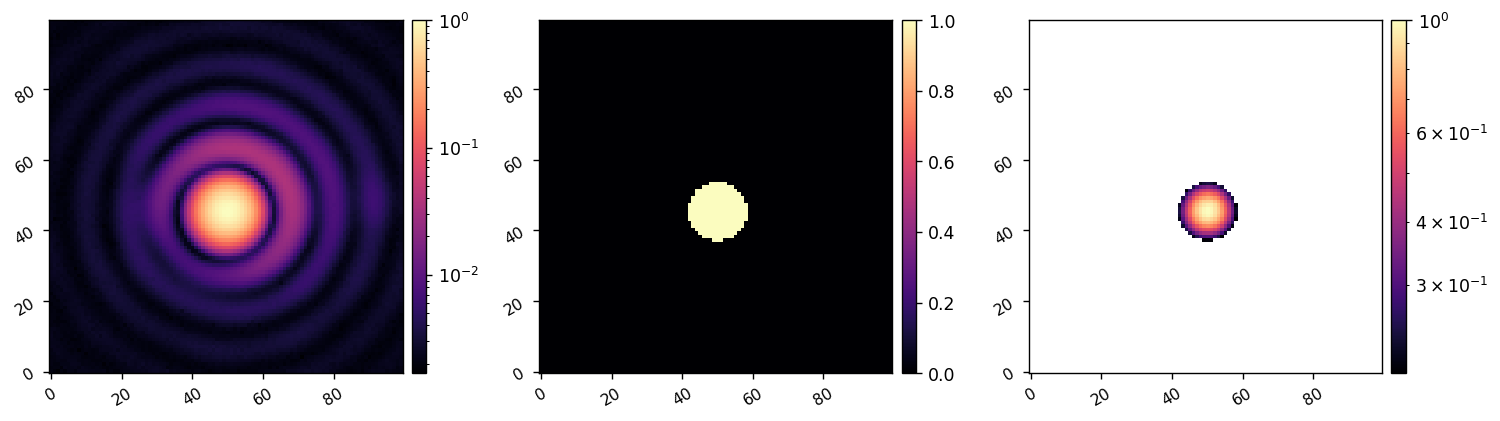

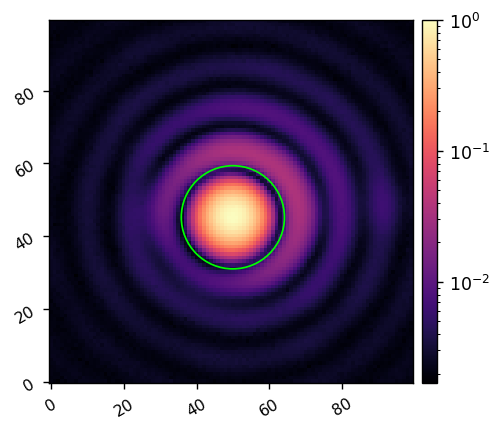

In [3]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [4]:
fsm = ImageStream('fsm')

In [5]:
fsm.write(v_bias)

# Record a short time series at the sampling of the camera's framerate

In [34]:
t_total = 10*u.s
exp_time = client0[f'campupil.exptime.current']
fps = client0[f'campupil.fps.current']
hdr = {
    'EXPTIME':exp_time,
    'FPS':fps, 
    'T_TOTAL':t_total.to_value(u.s),
}

In [35]:
cam.Nframes = t_total.to_value(u.s)*fps
print(cam.Nframes)

frames = cam.snap_cube()

utils.save_fits(f'data/drift/{today}_short_drift_data_fsm_on.fits', frames, header=hdr, ow=True)


12453.2995605469
Saved data to:  data/drift/20241119_short_drift_data_fsm_on.fits


# Record a long time series with large temporal sampling.

In [28]:

t_total = 5*u.s
t_total = 30*u.min
freq = 5*u.Hz
Nexp_per_frame = 50

Nframes_total = t_total.to_value(u.s) * freq.to_value(u.Hz)
exp_time = client0[f'campupil.exptime.current']
fps = client0[f'campupil.fps.current']
print(Nframes_total, Nexp_per_frame)
print(1/freq.to_value(u.Hz), Nexp_per_frame/fps)
Nframes_total * 100**2 * 8 / 1e9

9000.0 50
0.2 0.040150001818316655


np.float64(0.72)

In [9]:
client0['fsmCtrl.adc_1.current']

-1.85278125

In [29]:

start = time.time()
end = start + t_total.to_value(u.s)
count = 0
frames = []
cam.Nframes = Nexp_per_frame
adcs = []
while time.time()<end:
    print(f"Capturing frame {count+1:d}. Time = {time.time()-start:.3f}s", end='')
    print("\r", end="")
    frames.append(cam.snap())
    adcs.append(np.array([client0['fsmCtrl.adc_1.current'], client0['fsmCtrl.adc_2.current'], client0['fsmCtrl.adc_3.current']]))
    count += 1
    time.sleep(1/freq.to_value(u.Hz) - cam.Nframes/fps)

frames = np.array(frames)

data = {
    'FRAMES':frames,
    'ADCS':adcs, 
    'FREQ':freq.to_value(u.Hz),
    'EXPTIME':exp_time,
    'NEXPS':Nexp_per_frame, 
    'FPS':fps, 
    'TIME':t_total.to_value(u.s),
}
utils.save_pickle(f'data/drift/{today}_long_drift_data_fsm_on_5.pkl', data)


Saved data to:  data/drift/20241204_long_drift_data_fsm_on_5.pkl


In [30]:
data['FRAMES'].shape

(8992, 100, 100)

In [39]:
5*1800

9000

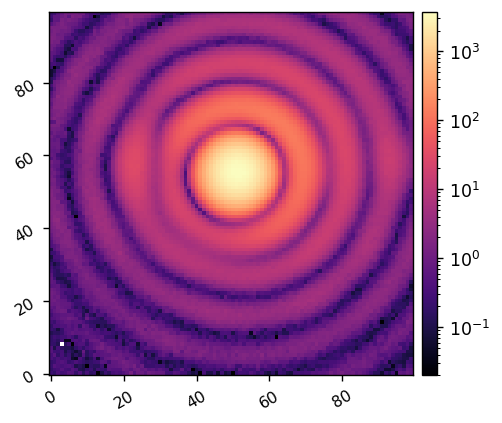

In [27]:
imshow1(frames[10], lognorm=True)